In [5]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
import matplotlib.pyplot as plt

# Can be None, "oversampling", "undersampling" or "weighted_loss" 
imbalance_strategy = None

In [6]:
# Import datasets
df_a = pd.read_parquet('../../data/set-a-imputed-scaled.parquet').sort_values(by=['RecordID','Time'])
df_b = pd.read_parquet('../../data/set-b-imputed-scaled.parquet').sort_values(by=['RecordID','Time'])
df_c = pd.read_parquet('../../data/set-c-imputed-scaled.parquet').sort_values(by=['RecordID','Time'])

# Get labels
outcomes_a = pd.read_csv('../../data/Outcomes-a.txt').sort_values(by=['RecordID'])[['RecordID', 'In-hospital_death']]
outcomes_b = pd.read_csv('../../data/Outcomes-b.txt').sort_values(by=['RecordID'])[['RecordID', 'In-hospital_death']]
outcomes_c = pd.read_csv('../../data/Outcomes-c.txt').sort_values(by=['RecordID'])[['RecordID', 'In-hospital_death']]

In [7]:
# Define static parameters
static_params = ['Age','Gender','Height', 'Weight(static)', 'RecordID']

# Select dynamic numeric columns (excluding static params)
dynamic_numeric_cols_a = [col for col in df_a.select_dtypes(include=['number']).columns if col not in static_params]
dynamic_numeric_cols_b = [col for col in df_b.select_dtypes(include=['number']).columns if col not in static_params]
dynamic_numeric_cols_c = [col for col in df_c.select_dtypes(include=['number']).columns if col not in static_params]

# Define aggregation logic
aggregation_funcs_a = {col: 'mean' for col in dynamic_numeric_cols_a}
aggregation_funcs_a.update({col: 'first' for col in static_params})
aggregation_funcs_b = {col: 'mean' for col in dynamic_numeric_cols_b}
aggregation_funcs_b.update({col: 'first' for col in static_params})
aggregation_funcs_c = {col: 'mean' for col in dynamic_numeric_cols_c}
aggregation_funcs_c.update({col: 'first' for col in static_params})


# Group by RecordID and aggregate only numeric columns
df_mean_a = df_a.groupby('RecordID').agg(aggregation_funcs_a)
df_mean_b = df_b.groupby('RecordID').agg(aggregation_funcs_b)
df_mean_c = df_c.groupby('RecordID').agg(aggregation_funcs_c)

X_train = df_mean_a
X_val = df_mean_b
X_test = df_mean_c
X_test = X_test[X_train.columns]





# Get labels
y_train = outcomes_a['In-hospital_death']
y_val = outcomes_b['In-hospital_death']
y_test = outcomes_c['In-hospital_death']


if imbalance_strategy == "oversampling":
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

if imbalance_strategy == "undersampling":
    cc = ClusterCentroids(random_state=42)
    X_train, y_train = cc.fit_resample(X_train, y_train)


Random Forest Results:
  - AuROC: 0.8061
  - AuPRC: 0.4503


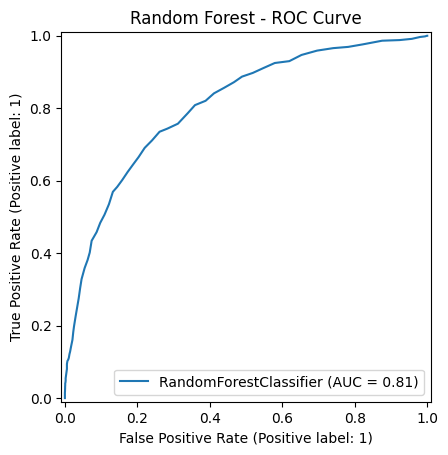

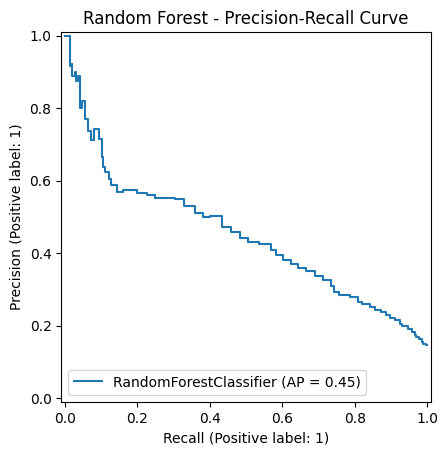

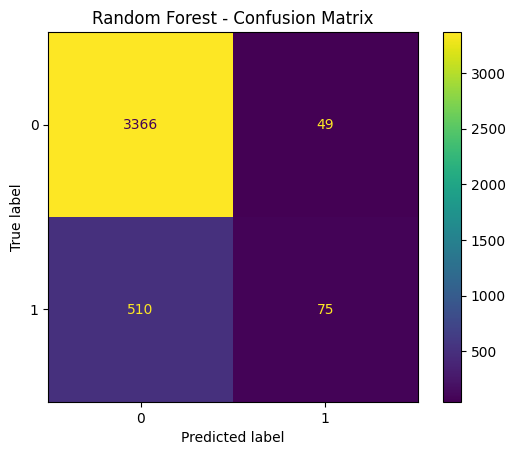

/mnt/c/Users/Elias/OneDrive - ETH Zurich/2025SS/Machine Learning for Healthcare/MLH4-Project-1/testvenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Results:
  - AuROC: 0.8175
  - AuPRC: 0.4265


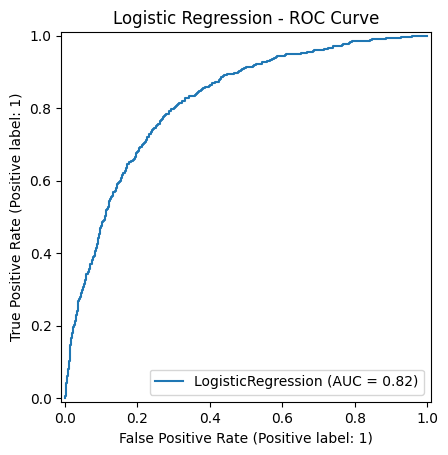

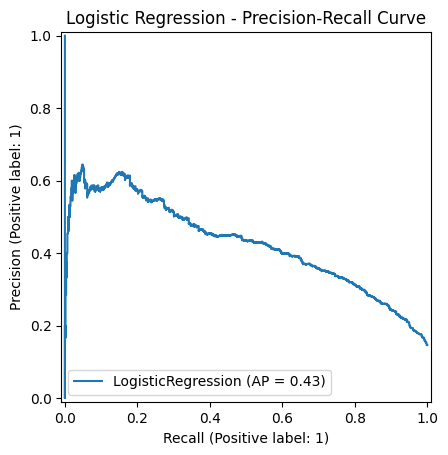

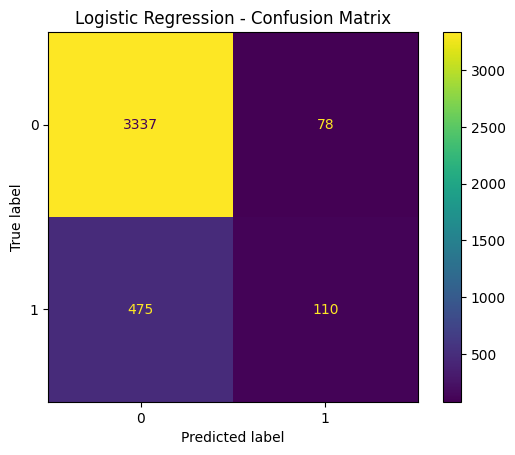

In [8]:
classifiers = {
    "Random Forest": RandomForestClassifier(
        random_state=42, 
        class_weight="balanced" if imbalance_strategy == "weighted_loss" else None
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight="balanced" if imbalance_strategy == "weighted_loss" else None
    )
}


for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)

    print(f"\n{name} Results:")
    print(f"  - AuROC: {auroc:.4f}")
    print(f"  - AuPRC: {auprc:.4f}")

    # Plot ROC Curve
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f'{name} - ROC Curve')
    plt.show()

    # Plot Precision-Recall Curve
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f'{name} - Precision-Recall Curve')
    plt.show()

    # Plot Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

